# 7.2 Different ways to build Keras models

There are three APIs for building models in Keras:
- The Sequential model, the most approachable API—it’s basically a Python list. As such, it’s limited to simple stacks of layers.
- The Functional API, which focuses on graph-like model architectures. It represents a nice mid-point between usability and flexibility, and as such, it’s the most commonly used model-building API.
- Model subclassing, a low-level option where you write everything yourself from scratch. This is ideal if you want full control over every little thing. However, you won’t get access to many built-in Keras features, and you will be more at risk of making mistakes.

## 7.2.1 The Sequential model

### *The `Sequential` class*

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

### *Incrementially building a Sequential model*

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

You saw in chapter 4 that layers only get built (which is to say, create their weights) when
they are called for the first time. That’s because the shape of the layers' weights depends
on the shape of their input: until the input shape is known, they can’t be created.
 As such, the preceding Sequential model does not have any weights until you actually call it on some data, or call its `build()` method with an input shape.
 
 ### *Models that aren't built have no weights*

In [3]:
try: model.weights
except: print("ValueError: Weights for model 'sequential_1' have not yet been created. Weights are created when the model is first called on inputs or `build()` is called with an `input_shape`.")

ValueError: Weights for model 'sequential_1' have not yet been created. Weights are created when the model is first called on inputs or `build()` is called with an `input_shape`.


### *Calling a model for the first time to build it*

In [4]:
# Builds the model—now the model will expect samples of shape (3,). The
# None in the input shape signals that the batch size could be anything.
model.build(input_shape=(None, 3))
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.24337009,  0.22791457, -0.0453462 ,  0.02879596, -0.00986463,
          0.08332887, -0.12102023, -0.24046609, -0.15935962,  0.26339585,
         -0.27476922, -0.17202678, -0.09314379,  0.22764754,  0.11960769,
         -0.26715168, -0.19212215,  0.19386524,  0.16347337, -0.23775482,
          0.02152681,  0.27077508,  0.06392565,  0.24474889,  0.07846832,
         -0.09819339, -0.02048141, -0.00388402, -0.05500266, -0.03163111,
          0.23641247,  0.14188698, -0.21450448, -0.0762911 , -0.03044409,
         -0.05756688,  0.24083549,  0.12736279, -0.04945818,  0.26263094,
         -0.23041952, -0.23405167,  0.23366797, -0.05293666, -0.10324751,
          0.03736416,  0.26856083,  0.02155676, -0.26522738, -0.03349277,
         -0.1595666 ,  0.22236091, -0.041457  , -0.10135187,  0.18422654,
          0.2724638 , -0.00736848,  0.25835502,  0.08340499, -0.18634301,
          0.23455381, -0.04676697, -0.22540

### *The `summary()` method*

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### *Naming models and layers with the `name` argument*

In [6]:
model = keras.Sequential(name='my_example_model')
model.add(layers.Dense(64, activation='relu', name='my_first_layer'))
model.add(layers.Dense(10, activation='relu', name='my_last_layer'))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


When building a Sequential model incrementally, it’s useful to be able to print a summary of what the current model looks like after you add each layer. But you can’t print
a summary until the model is built! There’s actually a way to have your `Sequential`
built on the fly: just declare the shape of the model’s inputs in advance. You can do
this via the `Input` class.

### *Specifying the input shape of your model in advance*

In [7]:
model = keras.Sequential()
# Use Input to declare the shape of the inputs. Note that the shape argument 
# must be the shape of each sample, not the shape of one batch.
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


## 7.2.2 The Functional API

The Sequential model is easy to use, but its applicability is extremely limited: it can
only express models with a single input and a single output, applying one layer after
the other in a sequential fashion. In practice, it’s pretty common to encounter models
with multiple inputs (say, an image and its metadata), multiple outputs (different
things you want to predict about the data), or a nonlinear topology.

 In such cases, you’d build your model using the Functional API. This is what most
Keras models you’ll encounter in the wild use. It’s fun and powerful—it feels like playing with LEGO bricks.

### 7.2.2.1 A simple example

Let’s start with something simple: the stack of two layers we used in the previous section. Its Functional API version looks like the following listing.

### *A simple Functional model with two Dense layers*

We started by declaring an `Input`. This `inputs` object holds information about the shape and dtype of the data that the
model will process:

In [9]:
inputs = keras.Input(shape=(3,), name='my_input')

# The model will process batches where each sample has shape (3,). 
# The number of samples per batch is variable (indicated by the None batch size).

print(inputs.shape, inputs.dtype)

(None, 3) <dtype: 'float32'>


We call such an object a *symbolic tensor*. It doesn’t contain any actual data, but it
encodes the specifications of the actual tensors of data that the model will see when
you use it. It *stands for* future tensors of data.

Next, we created a layer and called it on the input. All Keras layers can be called both on real tensors of data and on these symbolic tensors. In the latter case, they return a new symbolic tensor, with updated shape and
dtype information:

In [10]:
features = layers.Dense(64, activation='relu')(inputs)
print(features.shape, features.dtype)

(None, 64) <dtype: 'float32'>


After obtaining the final outputs, we instantiated the model by specifying its inputs
and outputs in the `Model` constructor:

In [11]:
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 7.2.2.2 Multi-input, multi-output models

Most deep learning models don’t look like lists—they look like
graphs. They may, for instance, have multiple inputs or multiple outputs. It’s for this
kind of model that the Functional API really shines.

 Let’s say you’re building a system to rank customer support tickets by priority and
route them to the appropriate department. Your model has three inputs:
- The title of the ticket (text input)
- The text body of the ticket (text input)
- Any tags added by the user (categorical input, assumed here to be one-hot encoded)

We can encode the text inputs as arrays of ones and zeros of size `vocabulary_size`
(see chapter 11 for detailed information about text encoding techniques).

 Your model also has two outputs:
- The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
- The department that should handle the ticket (a softmax over the set of departments)

You can build this model in a few lines with the Functional API.

### *A multi-input, multi-output Functional model*

In [12]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# Define model inputs.
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags") 

# Combine input features into a single tensor, features, by concatenating them.
features = layers.Concatenate()([title, text_body, tags])
# Apply an intermediate layer to recombine input features into richer representations.
features = layers.Dense(64, activation="relu")(features)

# Define model outputs.
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features) 

# Create the model by specifying its inputs and outputs.
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department]) 

### 7.2.2.3 Training a multi-input, multi-output model

You can train your model in much the same way as you would train a Sequential
model, by calling `fit()` with lists of input and output data. These lists of data should
be in the same order as the inputs you passed to the `Model` constructor.

### *Training a model by providing lists of input and target arrays*

In [13]:
import numpy as np
num_samples = 1280

# Dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags)) 
# Dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer='rmsprop', 
              loss=['mean_squared_error', 'categorical_crossentropy'], 
              metrics=[['mean_absolute_error'], ['accuracy']])

model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)

model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 6ms/step


If you don’t want to rely on input order (for instance, because you have many inputs
or outputs), you can also leverage the names you gave to the Input objects and the
output layers, and pass data via dictionaries.

### *Training a model by providing dicts of input and target arrays*

In [14]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"}, 
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data}, 
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 6ms/step


### 7.2.2.4 The power of the Functional API: Access to layer connectivity

A Functional model is an explicit graph data structure. This makes it possible to
inspect how layers are connected and reuse previous graph nodes (which are layer
outputs) as part of new models. It also nicely fits the “mental model” that most researchers use when thinking about a deep neural network: a graph of layers. This enables
two important use cases: model visualization and feature extraction.
 Let’s visualize the connectivity of the model we just defined (the *topology* of the
model). You can plot a Functional model as a graph with the `plot_model()` utility.

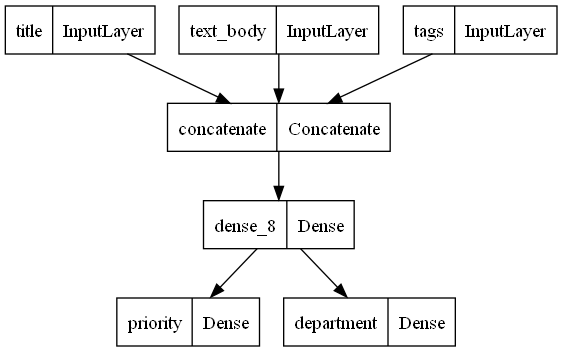

In [19]:
import os
os.environ['PATH'] += os.pathsep + "D:/Graphviz/bin"
from tensorflow.keras.utils import plot_model
plot_model(model, 'ticket_classifier.png')

You can add to this plot the input and output shapes of each layer in the model, which
can be helpful during debugging.

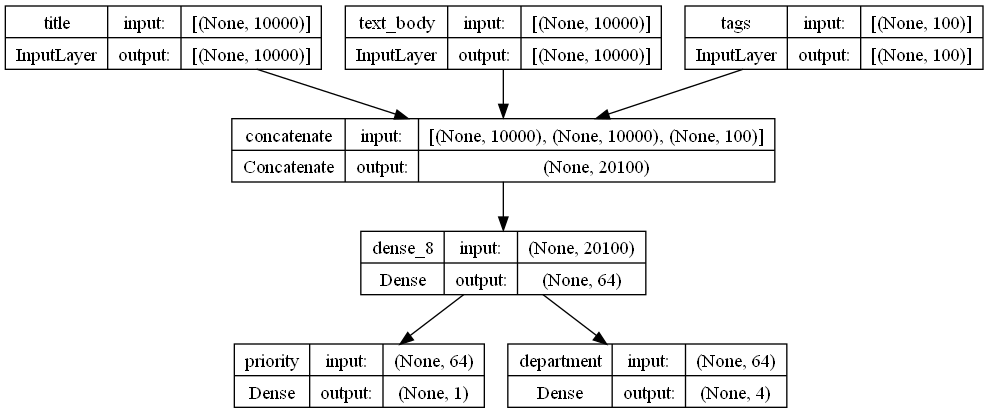

In [20]:
plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

The “None” in the tensor shapes represents the batch size: this model allows batches
of any size.

 Access to layer connectivity also means that you can inspect and reuse individual
nodes (layer calls) in the graph. The `model.layers` model property provides the list
of layers that make up the model, and for each layer you can query `layer.input` and
`layer.output`.

### *Retrieving the inputs or outputs of a layer in a Functional model*

In [21]:
model.layers

In [22]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [23]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

This enables you to do *feature extraction*, creating models that reuse intermediate features from another model.

 Let’s say you want to add another output to the previous model—you want to estimate how long a given issue ticket will take to resolve, a kind of difficulty rating. You
could do this via a classification layer over three categories: “quick,” “medium,” and
“difficult.” You don’t need to recreate and retrain a model from scratch. You can start
from the intermediate features of your previous model, since you have access to them,
like this.

### *Creating a new model by reusing intermediate layer outputs*

In [27]:
# layers[4] is our intermediate Dense layer
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department, difficulty])

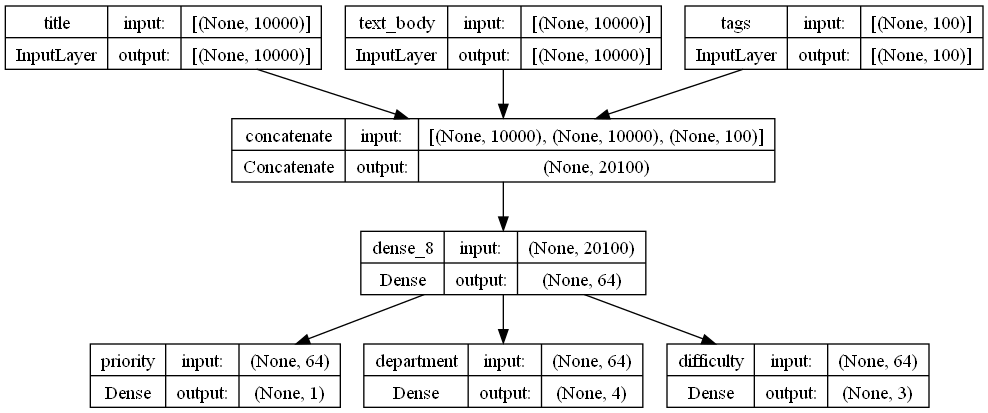

In [28]:
plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

## 7.2.3 Subclassing the Model class

The last model-building pattern you should know about is the most advanced one:
Model subclassing. You learned in chapter 3 how to subclass the Layer class to create
custom layers. Subclassing Model is pretty similar:
- In the `__init__()` method, define the layers the model will use.
- In the `call()` method, define the forward pass of the model, reusing the layers previously created.
- Instantiate your subclass, and call it on data to create its weights.

### 7.2.3.1 Rewriting our previous example as a subclassed model
Let’s take a look at a simple example: we will reimplement the customer support ticket
management model using a `Model` subclass.
### *A simple subclassed model*

In [31]:
class CustomerTicketModel(keras.Model):
    
    def __init__(self, num_departments):
        super().__init__()
        # Define sublayers in the constructor.
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(num_departments, activation='softmax')
        
    def call(self, inputs):
        # Define the forward pass in the call() method.
        title = inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']
        
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

Once you’ve defined the model, you can instantiate it. Note that it will only create its
weights the first time you call it on some data, much like `Layer` subclasses:

In [32]:
model = CustomerTicketModel(num_departments=4)
priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

So far, everything looks very similar to `Layer` subclassing, a workflow you encountered
in chapter 3. What, then, is the difference between a `Layer` subclass and a `Model` subclass? It’s simple: a “layer” is a building block you use to create models, and a “model”
is the top-level object that you will actually train, export for inference, etc. In short, a
`Model` has `fit()`, `evaluate()`, and `predict()` methods. Layers don’t. Other than that,
the two classes are virtually identical. (Another difference is that you can *save* a model
to a file on disk, which we will cover in a few sections.)
 You can compile and train a `Model` subclass just like a Sequential or Functional
model:

In [33]:
# The structure of what you pass as the loss and metrics arguments must match exactly what gets
# returned by call()—here, a list of two elements.
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

# The structure of the input data must match exactly what is expected by the call() method—
# here, a dict with keys title, text_body, and tags.
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          # The structure of the target data must match exactly what is
          # returned by the call() method—here, a list of two elements.
          [priority_data, department_data],
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               [priority_data, department_data])

priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 5ms/step


The `Model` subclassing workflow is the most flexible way to build a model. It enables
you to build models that cannot be expressed as directed acyclic graphs of layers—
imagine, for instance, a model where the `call()` method uses layers inside a for loop,
or even calls them recursively. Anything is possible—you’re in charge.

### 7.2.3.2 Beware: What subclassed models don't support

This freedom comes at a cost: with subclassed models, you are responsible for more of
the model logic, which means your potential error surface is much larger. As a result,
you will have more debugging work to do. You are developing a new Python object,
not just snapping together LEGO bricks.

Functional and subclassed models are also substantially different in nature. A Functional model is an explicit data structure—a graph of layers, which you can view, inspect,
and modify. A subclassed model is a piece of bytecode—a Python class with a `call()`
method that contains raw code. This is the source of the subclassing workflow’s flexibility—you can code up whatever functionality you like—but it introduces new limitations.

 For instance, because the way layers are connected to each other is hidden inside
the body of the `call()` method, you cannot access that information. Calling `summary()` will not display layer connectivity, and you cannot plot the model topology via
`plot_model()`. Likewise, if you have a subclassed model, you cannot access the nodes
of the graph of layers to do feature extraction because there is simply no graph. Once
the model is instantiated, its forward pass becomes a complete black box. 

## 7.2.4 Mixing and matching different components

Crucially, choosing one of these patterns—the Sequential model, the Functional API,
or `Model` subclassing—does not lock you out of the others. All models in the Keras API
can smoothly interoperate with each other, whether they’re Sequential models, Functional models, or subclassed models written from scratch. They’re all part of the same
spectrum of workflows.

 For instance, you can use a subclassed layer or model in a Functional model.
 
### *Creating a Functional model that includes a subclassed model*

In [34]:
class Classifier(keras.Model):
    
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = 'sigmoid'
        else:
            num_units = num_classes
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation=activation)
        
    def call(self, inputs):
        return self.dense(inputs)
    
inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

Inversely, you can use a Functional model as part of a subclassed layer or model. 

### *Creating a subclassed model that includes a Functional model*

In [35]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):
    
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier
    
    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

## 7.2.5 Remember: Use the right tool for the job

You’ve learned about the spectrum of workflows for building Keras models, from the
simplest workflow, the Sequential model, to the most advanced one, model subclassing. When should you use one over the other? Each one has its pros and cons—pick
the one most suitable for the job at hand.

 In general, the Functional API provides you with a pretty good trade-off between
ease of use and flexibility. It also gives you direct access to layer connectivity, which is
very powerful for use cases such as model plotting or feature extraction. If you can use
the Functional API—that is, if your model can be expressed as a directed acyclic graph
of layers—I recommend using it over model subclassing.
 
 Going forward, all examples in this book will use the Functional API, simply
because all the models we will work with are expressible as graphs of layers. We will,
however, make frequent use of subclassed layers. In general, using Functional models
that include subclassed layers provides the best of both worlds: high development flexibility while retaining the advantages of the Functional API. 